##### LOADING NECESSARY LIBRARIES AND CREATING NECESSARY FUNCTIONS

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import custom_vgg22
import preloaded_vgg22
import os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# function to load preloaded VGGNet model on custom VGGNet model architecture
def model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_initial_weights.h5'):
    """
    input:
    weights -- weights of the base VGGNet model

    output:
    tf.keras.Model -- VGG22 Model with preloaded_VGG weights but custom_VGG architecture
    
    """
    # purpose of this function is to make later weights and biases comparisons easier
    # by providing the same architecture to both the models
    
    base_model = preloaded_vgg22.cifar10_VGG22()   # loading preloaded VGG22 model
    base_model.load_weights(weights)
    
    preload_model = custom_vgg22.cifar10_custom_VGG22()  # loading custom VGG22 model

    i = 2
    # assigning weights correspondingly from preloaded model to custom model
    for layer in base_model.layers[3].layers:
        preload_model.layers[i].set_weights(layer.weights)  # VGGNet architecture
        i += 1
    
    preload_model.layers[i].set_weights(base_model.layers[4].weights)       # batchnormalization layer
    preload_model.layers[i+3].set_weights(base_model.layers[7].weights)     # fc1 dense layer
    preload_model.layers[i+5].set_weights(base_model.layers[9].weights)     # fc2 dense layer
    preload_model.layers[i+7].set_weights(base_model.layers[11].weights)    # fc3 dense layer
    preload_model.layers[i+9].set_weights(base_model.layers[13].weights)    # fc4 dense layer
    preload_model.layers[i+11].set_weights(base_model.layers[15].weights)   # predictions layer

    return preload_model

In [4]:
# function to generate statistics on the data
def stats_calc(model=tf.keras.Model, stat='avg'):
    """
    input:
    model -- tf.keras.Model whose weights and biases to perform the action on
    stat -- the statistical action to perform ('avg' for mean, 'std' for standard deviation, 'ran' for range)

    output:
    dictionary -- a dictionary {model_layer_name_w: 'stat' operation result on model_layer_weights,
                                model_layer_name_b: 'stat' operation result on model_layer_biases,...}
    """
    stat_data = {}

    for i in range(len(model.layers)):  # looping through the model
        if model.layers[i].weights != []:  # excluding layers without weights and biases
            if stat == 'avg':  # calculating average given the condition
                stat_data[model.layers[i].name + '_w'] = np.mean(model.layers[i].get_weights()[0].flatten())
                stat_data[model.layers[i].name + '_b'] = np.mean(model.layers[i].get_weights()[1])
            if stat == 'std':  # calculating standard deviation given the condition
                stat_data[model.layers[i].name + '_w'] = np.std(model.layers[i].get_weights()[0].flatten())
                stat_data[model.layers[i].name + '_b'] = np.std(model.layers[i].get_weights()[1])
            if stat == 'ran':  # calculating range given the condition
                stat_data[model.layers[i].name + '_w'] = np.max(model.layers[i].get_weights()[0].flatten()) - np.min(model.layers[i].get_weights()[0].flatten())
                stat_data[model.layers[i].name + '_b'] = np.max(model.layers[i].get_weights()[1]) - np.min(model.layers[i].get_weights()[1])

    return stat_data

In [5]:
# function to transform dictionary to Pandas DataFrame
def dict_to_DF(g_dict={}, model_name='model'):
    """
    input:
    g_dict -- a dictionary {model_layer_name_w: 'stat' operation result on model_layer_weights,
                                model_layer_name_b: 'stat' operation result on model_layer_biases,...}
    model_name -- the name of the model as a string (either 'Preload VGG22' or 'Custom VGG22')

    output:
    Pandas DataFrame -- a Pandas DataFrame ready for Seaborn visualization
    
    """
    data = pd.DataFrame(list(g_dict.items()), columns=['layer', 'value'])  # creating DataFrame
    # generating value category if it is a weight or a bais
    data['value_category'] = data['layer'].apply(lambda x: 'Weights' if x[-1:] == 'w' else 'Biases')
    # renaming layer to drop '_w' or '_b' at the end
    data['layer'] = data['layer'].apply(lambda x: x[:-2])
    # generating a column with model name
    data['model'] = data.apply(lambda x: model_name, axis=1)

    return data

### CHECKPOINT 1 WEIGHTS & BIASES

In [6]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_1.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_1.h5')

In [7]:
# calculating preloaded model's statistics per layer for weights and biases
preload_model_mean_data = stats_calc(model=preload_model, stat='avg')
preload_model_std_data = stats_calc(model=preload_model, stat='std')
preload_model_range_data = stats_calc(model=preload_model, stat='ran')

In [8]:
# calculating custom model's statistics per layer for weights and biases
custom_model_mean_data = stats_calc(model=custom_model, stat='avg')
custom_model_std_data = stats_calc(model=custom_model, stat='std')
custom_model_range_data = stats_calc(model=custom_model, stat='ran')

In [9]:
# putting together the mean calculations DataFrame
mean_data = pd.concat([dict_to_DF(g_dict=preload_model_mean_data, model_name='Preload VGG22'),
                       dict_to_DF(g_dict=custom_model_mean_data, model_name='Custom VGG22')], ignore_index=True)

In [10]:
# putting together the standard deviation calculations DataFrame
std_data = pd.concat([dict_to_DF(g_dict=preload_model_std_data, model_name='Preload VGG22'),
                      dict_to_DF(g_dict=custom_model_std_data, model_name='Custom VGG22')], ignore_index=True)

In [11]:
# putting together the standard deviation calculations DataFrame
range_data = pd.concat([dict_to_DF(g_dict=preload_model_range_data, model_name='Preload VGG22'),
                        dict_to_DF(g_dict=custom_model_range_data, model_name='Custom VGG22')], ignore_index=True)

In [12]:
# setting checkpoint values to 'Checkpoint 1'
mean_data['checkpoint'] = 'Checkpoint 1'
std_data['checkpoint'] = 'Checkpoint 1'
range_data['checkpoint'] = 'Checkpoint 1'

In [13]:
# assigning new Pandas DataFrames to store all values
overall_mean_data = mean_data
overall_std_data = std_data
overall_range_data = range_data

### CHECKPOINT 2 WEIGHTS & BIASES

In [14]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_2.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_2.h5')

In [15]:
# calculating preloaded model's statistics per layer for weights and biases
preload_model_mean_data = stats_calc(model=preload_model, stat='avg')
preload_model_std_data = stats_calc(model=preload_model, stat='std')
preload_model_range_data = stats_calc(model=preload_model, stat='ran')

In [16]:
# calculating custom model's statistics per layer for weights and biases
custom_model_mean_data = stats_calc(model=custom_model, stat='avg')
custom_model_std_data = stats_calc(model=custom_model, stat='std')
custom_model_range_data = stats_calc(model=custom_model, stat='ran')

In [17]:
# putting together the mean calculations DataFrame
mean_data = pd.concat([dict_to_DF(g_dict=preload_model_mean_data, model_name='Preload VGG22'),
                       dict_to_DF(g_dict=custom_model_mean_data, model_name='Custom VGG22')], ignore_index=True)

In [18]:
# putting together the standard deviation calculations DataFrame
std_data = pd.concat([dict_to_DF(g_dict=preload_model_std_data, model_name='Preload VGG22'),
                      dict_to_DF(g_dict=custom_model_std_data, model_name='Custom VGG22')], ignore_index=True)

In [19]:
# putting together the standard deviation calculations DataFrame
range_data = pd.concat([dict_to_DF(g_dict=preload_model_range_data, model_name='Preload VGG22'),
                        dict_to_DF(g_dict=custom_model_range_data, model_name='Custom VGG22')], ignore_index=True)

In [20]:
# setting checkpoint values to 'Checkpoint 2'
mean_data['checkpoint'] = 'Checkpoint 2'
std_data['checkpoint'] = 'Checkpoint 2'
range_data['checkpoint'] = 'Checkpoint 2'

In [21]:
# concatinating checkpoint 2 values to previous DataFrames to store all values
overall_mean_data = pd.concat([overall_mean_data, mean_data], ignore_index=True)
overall_std_data = pd.concat([overall_std_data, std_data], ignore_index=True)
overall_range_data = pd.concat([overall_range_data, range_data], ignore_index=True)

### CHECKPOINT 3 WEIGHTS & BIASES

In [22]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_3.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_3.h5')

In [23]:
# calculating preloaded model's statistics per layer for weights and biases
preload_model_mean_data = stats_calc(model=preload_model, stat='avg')
preload_model_std_data = stats_calc(model=preload_model, stat='std')
preload_model_range_data = stats_calc(model=preload_model, stat='ran')

In [24]:
# calculating custom model's statistics per layer for weights and biases
custom_model_mean_data = stats_calc(model=custom_model, stat='avg')
custom_model_std_data = stats_calc(model=custom_model, stat='std')
custom_model_range_data = stats_calc(model=custom_model, stat='ran')

In [25]:
# putting together the mean calculations DataFrame
mean_data = pd.concat([dict_to_DF(g_dict=preload_model_mean_data, model_name='Preload VGG22'),
                       dict_to_DF(g_dict=custom_model_mean_data, model_name='Custom VGG22')])

In [26]:
# putting together the standard deviation calculations DataFrame
std_data = pd.concat([dict_to_DF(g_dict=preload_model_std_data, model_name='Preload VGG22'),
                      dict_to_DF(g_dict=custom_model_std_data, model_name='Custom VGG22')])

In [27]:
# putting together the standard deviation calculations DataFrame
range_data = pd.concat([dict_to_DF(g_dict=preload_model_range_data, model_name='Preload VGG22'),
                        dict_to_DF(g_dict=custom_model_range_data, model_name='Custom VGG22')])

In [28]:
# setting checkpoint values to 'Checkpoint 3'
mean_data['checkpoint'] = 'Checkpoint 3'
std_data['checkpoint'] = 'Checkpoint 3'
range_data['checkpoint'] = 'Checkpoint 3'

In [29]:
# concatinating checkpoint 3 values to previous DataFrames to store all values
overall_mean_data = pd.concat([overall_mean_data, mean_data], ignore_index=True)
overall_std_data = pd.concat([overall_std_data, std_data], ignore_index=True)
overall_range_data = pd.concat([overall_range_data, range_data], ignore_index=True)

### CHECKPOINT 4 WEIGHTS & BIASES

In [30]:
# loading both models with respective initial weights
custom_model = custom_vgg22.cifar10_custom_VGG22(weights='D:/CIFAR_10_stuff/weights/custom_VGG_checkpoint_4.h5')
preload_model = model_preload(weights='D:/CIFAR_10_stuff/weights/preload_VGG_checkpoint_4.h5')

In [31]:
# calculating preloaded model's statistics per layer for weights and biases
preload_model_mean_data = stats_calc(model=preload_model, stat='avg')
preload_model_std_data = stats_calc(model=preload_model, stat='std')
preload_model_range_data = stats_calc(model=preload_model, stat='ran')

In [32]:
# calculating custom model's statistics per layer for weights and biases
custom_model_mean_data = stats_calc(model=custom_model, stat='avg')
custom_model_std_data = stats_calc(model=custom_model, stat='std')
custom_model_range_data = stats_calc(model=custom_model, stat='ran')

In [33]:
# putting together the mean calculations DataFrame
mean_data = pd.concat([dict_to_DF(g_dict=preload_model_mean_data, model_name='Preload VGG22'),
                       dict_to_DF(g_dict=custom_model_mean_data, model_name='Custom VGG22')])

In [34]:
# putting together the standard deviation calculations DataFrame
std_data = pd.concat([dict_to_DF(g_dict=preload_model_std_data, model_name='Preload VGG22'),
                      dict_to_DF(g_dict=custom_model_std_data, model_name='Custom VGG22')])

In [35]:
# putting together the standard deviation calculations DataFrame
range_data = pd.concat([dict_to_DF(g_dict=preload_model_range_data, model_name='Preload VGG22'),
                        dict_to_DF(g_dict=custom_model_range_data, model_name='Custom VGG22')])

In [36]:
# setting checkpoint values to 'Checkpoint 4'
mean_data['checkpoint'] = 'Checkpoint 4'
std_data['checkpoint'] = 'Checkpoint 4'
range_data['checkpoint'] = 'Checkpoint 4'

In [37]:
# concatinating checkpoint 4 values to previous DataFrames to store all values
overall_mean_data = pd.concat([overall_mean_data, mean_data], ignore_index=True)
overall_std_data = pd.concat([overall_std_data, std_data], ignore_index=True)
overall_range_data = pd.concat([overall_range_data, range_data], ignore_index=True)

### DESCRIPTIVE STATISTICS VISUALIZATION

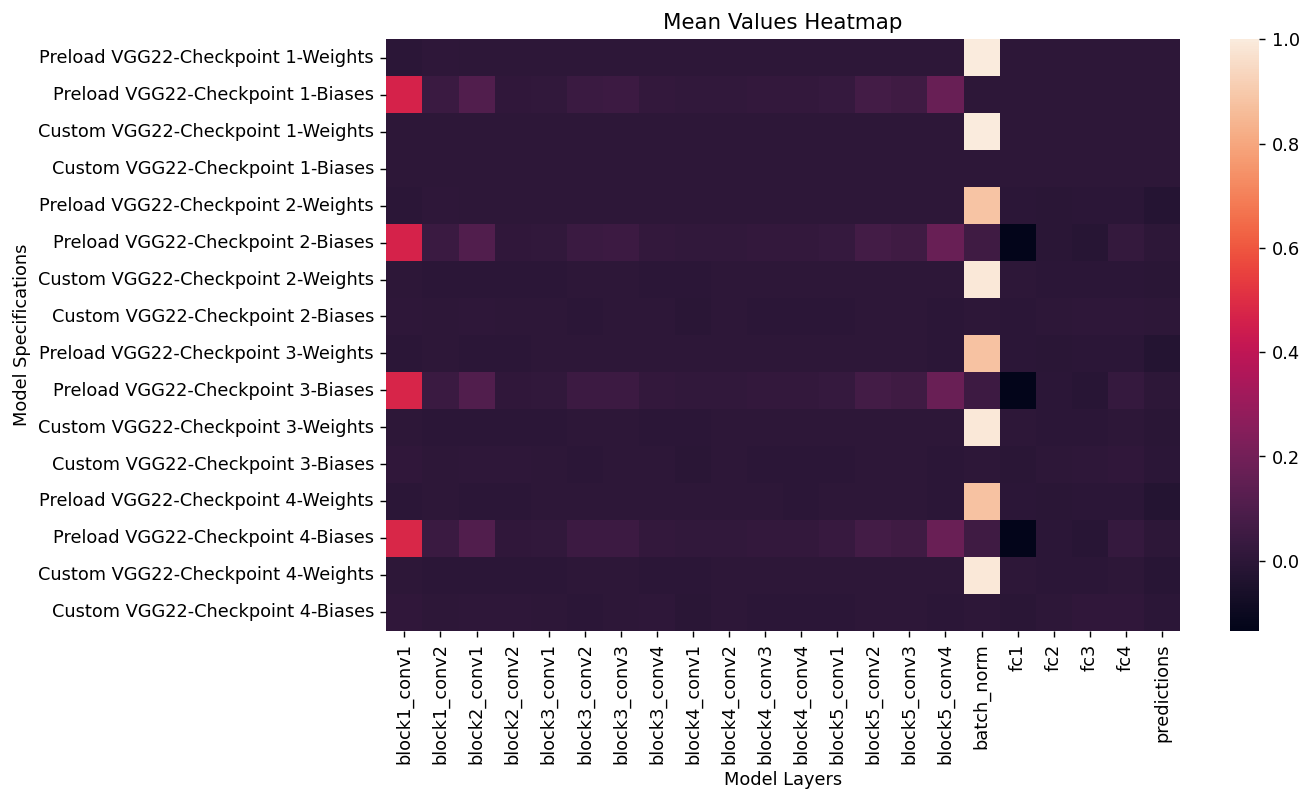

In [38]:
# mean data visualization
data = overall_mean_data.pivot(index="layer", columns=["model", "checkpoint", "value_category"], values="value")
data = data.reindex(overall_mean_data["layer"].unique())

plt.figure(figsize=(10, 6), dpi=128)

sns.heatmap(data.T)

plt.xlabel('Model Layers')
plt.ylabel('Model Specifications')
plt.title('Mean Values Heatmap')

plt.show()

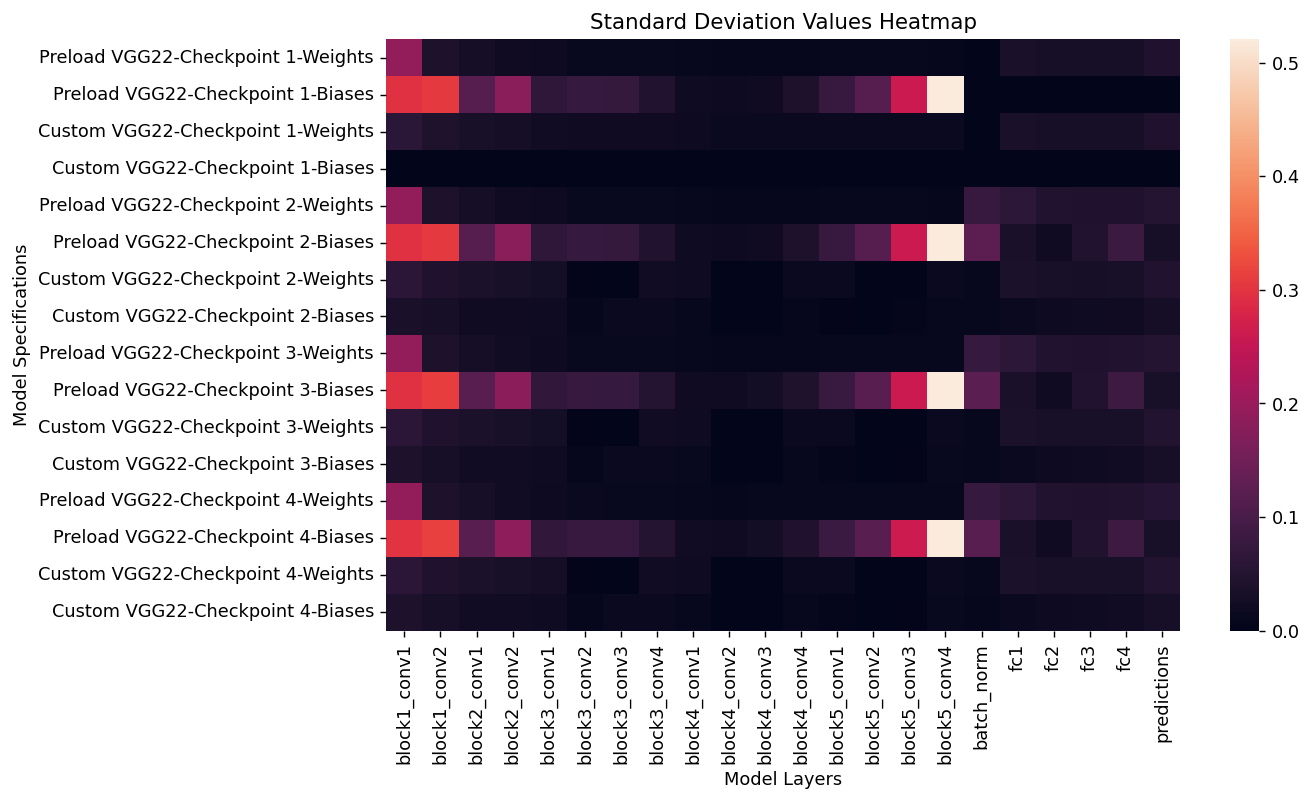

In [39]:
# standard deviation data visualization
data = overall_std_data.pivot(index="layer", columns=["model", "checkpoint", "value_category"], values="value")
data = data.reindex(overall_std_data["layer"].unique())

plt.figure(figsize=(10, 6), dpi=128)

sns.heatmap(data.T)

plt.xlabel('Model Layers')
plt.ylabel('Model Specifications')
plt.title('Standard Deviation Values Heatmap')

plt.show()

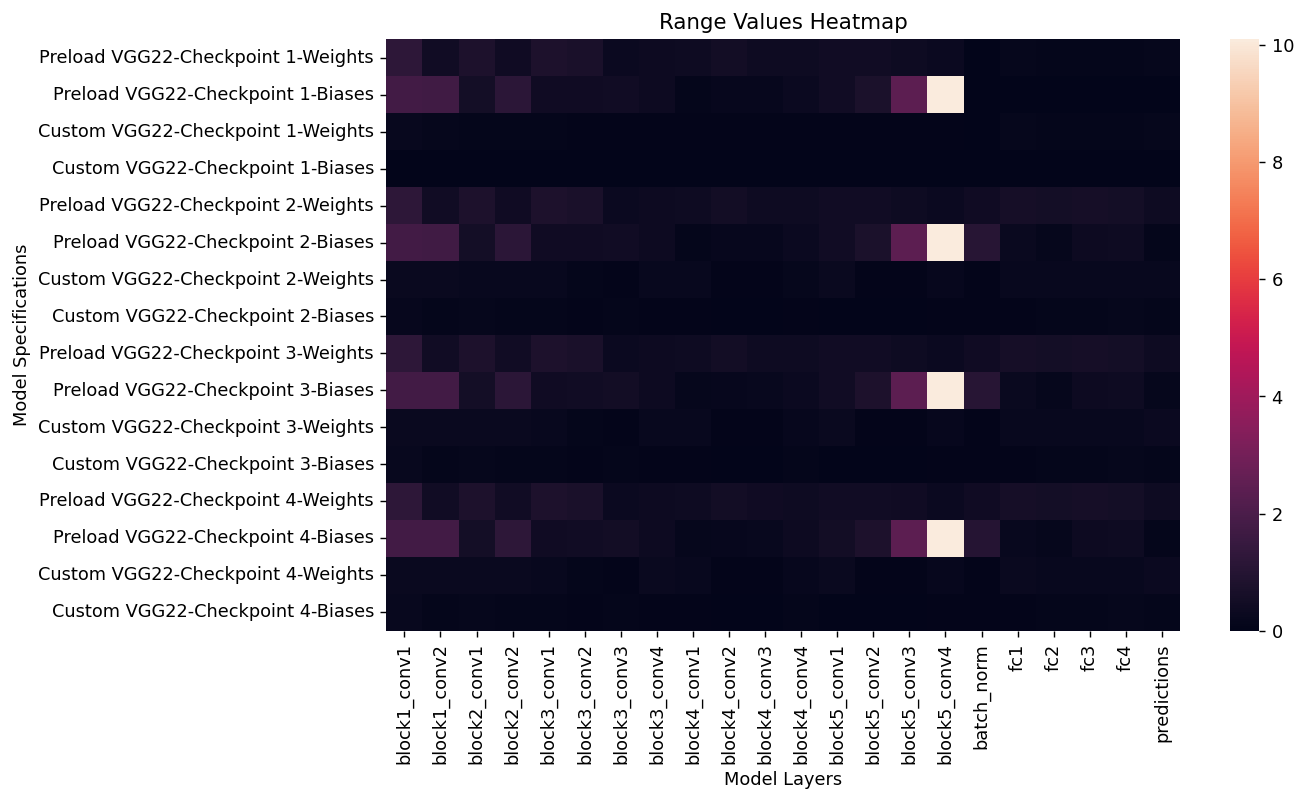

In [40]:
# range data visualization
data = overall_range_data.pivot(index="layer", columns=["model", "checkpoint", "value_category"], values="value")
data = data.reindex(overall_range_data["layer"].unique())

plt.figure(figsize=(10, 6), dpi=128)

sns.heatmap(data.T)

plt.xlabel('Model Layers')
plt.ylabel('Model Specifications')
plt.title('Range Values Heatmap')

plt.show()